In [2]:
from multiprocessing import Pool
import multiprocessing as mp
import os
os.environ['OMP_NUM_THREADS'] = "1"

import numpy as np

import astropy.units as u  
import astropy.constants as c
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib 

from astropy.io import fits
from astropy.table import Table, join
from astropy.wcs import WCS
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import spearmanr

from dustmaps.vergely2022 import Vergely2022Query
from dustmaps.edenhofer2023 import Edenhofer2023Query

import pickle 
import sys
import os
import tqdm
import datetime

import emcee
import corner

import h5py
import multiprocessing as mp

data_dir = '/uufs/chpc.utah.edu/common/home/astro/zasowski/mcbride/'

plt.rcParams['figure.facecolor'] = 'white'


/uufs/astro.utah.edu/common/home/u1371365/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
import globalvars
dust_data = globalvars.DustData()

In [4]:
map_fname = '/uufs/astro.utah.edu/common/home/u1371365/DIB_KT_CACloud/edenhofer_out.h5'

with h5py.File(map_fname, 'r') as f:
    edenhofer = np.array(f['data'])
    dust_data.intake_map(edenhofer)

/tmp/ipykernel_996968/2315330892.py:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  edenhofer = np.array(f['data'])


In [5]:
CA_meta = Table(fits.open(data_dir + '/data/230420_CAResiduals/CA_meta.fits')[1].data)
CAresdir = '/uufs/astro.utah.edu/common/home/u1371365/Data/230420_CAResiduals/'
CAMADGICSresdir = '/uufs/astro.utah.edu/common/home/u1371365/Data/230829_MADGICSResiduals/'
starhorsepath = '/uufs/chpc.utah.edu/common/home/sdss/dr17/env/APOGEE_STARHORSE/APOGEE_DR17_EDR3_STARHORSE_v2.fits'
starhorse = Table.read(starhorsepath, hdu = 1)
starhorse = starhorse['APOGEE_ID', 'dist16', 'dist50', 'dist84', 'AV16', 'AV50', 'AV84']

CA_meta = join(CA_meta, starhorse, keys = 'APOGEE_ID', join_type = 'left')

CA_meta_full = CA_meta.copy()

with open('/uufs/astro.utah.edu/common/home/u1371365/DIB_KT_CACloud/goodbad.pickle', mode = 'rb') as f:
    goodbad = pickle.load(f)

# added 02.01
data_criteria = (((CA_meta['SNR'] > 80) & (CA_meta['TEFF'] > 5000)) | (CA_meta['SNR'] > 150)) & (CA_meta['ASPCAP_CHI2_1'] > 1) & (CA_meta['ASPCAP_CHI2_1'] < 5)
print(np.sum(data_criteria))
CA_meta= CA_meta[data_criteria]

1010


In [6]:
from specfns import get_wavs, resample_interp, dopplershift, lambda0, sigma0
from filehandling import get_ca_res, get_madgics_res, get_medres
from spacefns_v2 import select_stars, find_nearest, find_radius, differentialAmplitude
from MCMCfns import logprob_2
from sightline import Sightline
import time

In [7]:
CA_meta = Table(fits.open(data_dir + '/data/230420_CAResiduals/CA_meta.fits')[1].data)
CAresdir = '/uufs/astro.utah.edu/common/home/u1371365/Data/230420_CAResiduals/'
CAMADGICSresdir = '/uufs/astro.utah.edu/common/home/u1371365/Data/230829_MADGICSResiduals/'
# starhorsepath = '/uufs/chpc.utah.edu/common/home/sdss/dr17/env/APOGEE_STARHORSE/APOGEE_DR17_EDR3_STARHORSE_v2.fits'
# starhorse = Table.read(starhorsepath, hdu = 1)
# starhorse = starhorse['APOGEE_ID', 'dist16', 'dist50', 'dist84', 'AV16', 'AV50', 'AV84']

# CA_meta = join(CA_meta, starhorse, keys = 'APOGEE_ID', join_type = 'left')

CA_meta_full = CA_meta.copy()

with open('/uufs/astro.utah.edu/common/home/u1371365/DIB_KT_CACloud/goodbad.pickle', mode = 'rb') as f:
    goodbad = pickle.load(f)

# added 02.01
data_criteria = (((CA_meta['SNR'] > 80) & (CA_meta['TEFF'] > 5000)) | (CA_meta['SNR'] > 150)) & (CA_meta['ASPCAP_CHI2_1'] > 1) & (CA_meta['ASPCAP_CHI2_1'] < 5)
print(np.sum(data_criteria))
CA_meta= CA_meta[data_criteria]

1010


In [8]:
lambda0 = 15272.42
from specfns import get_wavs

wavs = get_wavs()
window = (wavs > lambda0 -10) & (wavs < lambda0 + 10)
wavs_window = wavs[window]

In [9]:
ds = 1 # x downsampled
rad = 2

sample_dim_l = np.linspace(159, 167, int(8 / (ds * rad)))
sample_dim_b = np.linspace(-12.5 , -4.5, int(8 / (ds * rad)))
sample_grid_l, sample_grid_b = np.meshgrid(sample_dim_l, sample_dim_b)
grid_map_inds = np.array([find_nearest(sample_grid_l.flatten()[i], sample_grid_b.flatten()[i]) for i in range(len(sample_grid_l.flatten()))]).T
grid_map = np.nansum(np.copy(edenhofer[grid_map_inds[1], grid_map_inds[0], :]).reshape(*sample_grid_l.shape, -1), axis = 2)
grid_Nstar = np.array([np.nansum((np.abs((sample_grid_l.flatten()[i] - CA_meta['GLON'])) <= rad) & 
            (np.abs((sample_grid_b.flatten()[i] - CA_meta['GLAT'])) <= rad)) for i in range(len(sample_grid_l.flatten()))]).reshape(*sample_grid_l.shape)

# filament_l = (159, 169)
# filament_b = (-10, -6)

# N_min = 25
# radius_min = np.zeros(sample_grid_l.shape)
# mgrid = np.mgrid[0:len(sample_dim_l), 0:len(sample_dim_b)]
# for i in mgrid[0].flatten():
#     for j in mgrid[1].flatten():
#         radius_min[i, j] = find_radius(sample_grid_l[i, j], sample_grid_b[i, j], N_min, CA_meta)
#         radius_min[i, j] = np.max([radius_min[i, j], rad])

# radius_max = 0.4
# print(np.nansum(radius_min < radius_max))


# crit_filament = ((sample_grid_l > filament_l[0]) & (sample_grid_l < filament_l[1]) & 
#                  (sample_grid_b > filament_b[0]) & (sample_grid_b < filament_b[1]) &
#                  (grid_map > 2.2) & (radius_min < 0.5)) #(grid_Nstar > 5) & (grid_Nstar <= 10))

# crit_background =  (((sample_grid_l <= filament_l[0]) | (sample_grid_l >= filament_l[1]) |
#                  (sample_grid_b <= filament_b[0]) | (sample_grid_b >= filament_b[1])) &
#                  (grid_map <= 1.5) & (radius_min < radius_max)) #(grid_Nstar > 5) & (grid_Nstar <= 10))

# # crit_coverage = (np.sum() => 1 & )

# N_filament = np.sum(crit_filament)
# N_background = np.sum(crit_background)
# print(np.sum(crit_filament))
# print(np.sum(crit_background))
# l_fil, b_fil, AV_fil = (sample_grid_l[crit_filament].flatten(), sample_grid_b[crit_filament].flatten(),
#                         grid_map[crit_filament].flatten())
# l_off, b_off, AV_off = (sample_grid_l[crit_background].flatten(), sample_grid_b[crit_background].flatten(),
#                         grid_map[crit_background].flatten())

# l_sample, b_sample, AV_sample = (np.concatenate([l_fil, l_off]), np.concatenate([b_fil, b_off]),
#                                   np.concatenate([AV_fil, AV_off]))
# radius_min_fil = radius_min[crit_filament].flatten()
# radius_min_off = radius_min[crit_background].flatten()
# radius_sample = np.concatenate([radius_min_fil, radius_min_off])

# selected_inds = []
# for i in range(len(l_sample)):
#     l_center, b_center = l_sample[i], b_sample[i]
#     rad_i = radius_sample[i]
#     selection = select_stars(CA_meta, l_center, b_center, radius = rad_i)
#     # print(len(selection))
#     selected_inds.append(selection)

In [18]:

selected_inds = []
N_min_vals = [3, 5, 8, 10, 15, 20, 25, 30, 35, 40, 45, 50]
l_center, b_center = 165,-8.5
for N_min in N_min_vals:
    # N_min = 25
    radius_min = 0
    mgrid = np.mgrid[0:len(sample_dim_l), 0:len(sample_dim_b)]
    rad = find_radius(l_center, b_center, N_min, CA_meta)
    rad_sel = np.max([radius_min, rad])
    selection = select_stars(CA_meta, l_center, b_center, radius = rad_sel)
    # print(len(selection))
    selected_inds.append(selection)

In [19]:
dibfn = lambda x, mu, sigma, a: 1-a * np.exp(-0.5 * (x - mu)**2 / sigma**2)
def sigma_clip_mask(y, x = wavs, k = 2.5):
    y_over_gauss = None

    try:
        gaussfit = curve_fit(dibfn, x[window], y[window].filled(np.nan), p0 = (15272, 1.2, 0.05), bounds = ([15269, 0.5, 0], [15275, 2, 0.15]), check_finite = False, nan_policy = 'omit')

    except:
        # gaussfit = ((15272, 1.2, 0.05),())
        print('fail')
        return None, None
    #     y_over_gauss = None
    #     gaussfit = ((15272, 1.2, 0.05),())
    #     # fit = dibfn(x, 15272.42, 1.2, 0.05)
    #     # y_over_gauss = y / fit
    #     print('POOR GAUSS FIT IN SIGMA CLIP')
    y_over_gauss = y / dibfn(x, *gaussfit[0])

    med = np.nanmedian(y_over_gauss[window])
    stdev = np.std(y_over_gauss[window], ddof = 1)
    mask = np.abs(y_over_gauss - med) > k * stdev
    mask = mask + np.roll(mask, -1) + np.roll(mask, -1)
    mask = mask.astype(bool)
    return mask, stdev

def sigmaClip(y, yerr,k=2.5):
    clip = True
    clip_iters = 0
    std = np.nanstd(y[window], ddof = 1)
    mask = np.zeros(y.shape).astype(bool)
    clip_success = True

    while clip:
        clip_mask, std_clipped = sigma_clip_mask(np.ma.array(y, mask = mask.copy()), k = k)
        if clip_mask is None:
            clip_success = False
            return mask, clip_success
        clip_mask = clip_mask.filled(False)

        if std - std_clipped  < 1e-4:
            clip = False


        else:
            clip_iters += 1
            std = std_clipped
            mask = mask + clip_mask

    return mask, clip_success

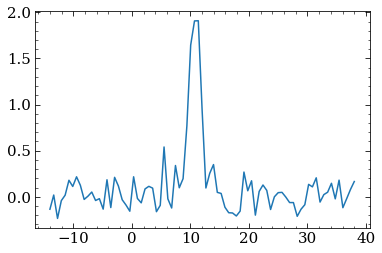

In [20]:
dataPath = '/uufs/chpc.utah.edu/common/home/astro/zasowski/mcbride/data/DHT21_Taurus_interp.fits'
hdulCO = fits.open(dataPath)

headerCO = hdulCO[0].header
dataCO = hdulCO[0].data
wcsCO = WCS(headerCO)

glon = headerCO['CRVAL2'] + headerCO['CDELT2'] * (np.arange(0, headerCO['NAXIS2'])- headerCO['CRPIX2'])
glat = headerCO['CRVAL3'] + headerCO['CDELT3'] * (np.arange(0, headerCO['NAXIS3'])- headerCO['CRPIX3'])
rvel = headerCO['CRVAL1'] + headerCO['CDELT1'] * (np.arange(0, headerCO['NAXIS1'])- headerCO['CRPIX1'])

l, b, v = np.meshgrid(glon, glat, rvel)
coord = SkyCoord(l * u.deg, b  * u.deg, radial_velocity = v * u.km/u.s, pm_l_cosb = 0 * u.deg/u.s,
                  pm_b = 0 * u.deg / u.s, distance = 500 * u.pc, frame = 'galacticlsr')

coord_icrs = coord.transform_to('icrs')

def get_CO_profile(l, b):
    coord_sel = SkyCoord(l = l * u.deg, b = b * u.deg, frame = 'galactic')
    pix_ind_l, pix_ind_b = wcsCO.world_to_pixel(0 * u.km/u.s, coord_sel)[1:]
    CO_profile = dataCO.T[:, int(pix_ind_l), int(pix_ind_b)]
    rvel = coord_icrs.T.radial_velocity[:, int(pix_ind_l), int(pix_ind_b)]
    return CO_profile, rvel
profile, rvel = get_CO_profile(165, -7)

plt.plot(rvel, profile)

In [21]:
def generateClippedResidual(aspcap, medres, apstar, rv, k = 3):
    spectrum = aspcap[1].data
    model = aspcap[3].data
    err = aspcap[2].data
    bitmask = apstar[3].data[0, :]

    if medres[1].data is None:
        medres_model = np.ones(spectrum.shape)
        medres_err =np.zeros(spectrum.shape)
    else:
        medres_model = np.array(medres[1].data)
        medres_err = np.array(medres[3].data)



    mask_digits = [0, 1, 2, 9, 12, 13] # 0 BADPIX, 1 CRPIX, 2 SATPIX, 9 PERSIST_HIGH, 12 SIG_SKYLINE, 13 SIG_TELLURIC
    mask = np.zeros(bitmask.shape)
    for digit in mask_digits:
        mask = mask + np.bitwise_and(bitmask.astype(int), 2**digit) 

    mask = mask.astype(bool)
    res_corr = spectrum / model / medres_model
    # print('res corr shape', res_corr.shape)
    uncertainty_corr = np.sqrt(err**2) #+ medres_err**2)

    sky_residuals = [(15268.1, 1),(15274.1, 1),(15275.9, 1)]
    manual_masks = np.zeros(len(wavs))
    for sky in sky_residuals:
        wl = sky[0]
        manual_masks[np.argmin(np.abs(wavs - wl))] = True
    manual_masks = manual_masks + np.roll(manual_masks, -1) + np.roll(manual_masks, 1)

    # mask_sigmaclip = np.zeros(len(wavs))


    maskSigClip, clip_success = sigmaClip(res_corr, uncertainty_corr, k = k)

    mask = mask + maskSigClip
    mask = mask.astype(bool)

    res_corr_ma = np.ma.array(res_corr, mask = mask)
    res_corr_filled = res_corr_ma.filled(np.nan)

    res_corr_resamp = resample_interp(res_corr_filled, rv)
    uncertainty_corr_resamp = resample_interp(uncertainty_corr, rv)

    sky_residuals = [(15268.1, 1),(15274.1, 1),(15275.9, 1)]
    manual_masks = np.zeros(len(wavs))
    for sky in sky_residuals:
        wl = sky[0]
        manual_masks[np.argmin(np.abs(wavs - wl))] = True
    manual_masks = manual_masks + np.roll(manual_masks, -1) + np.roll(manual_masks, 1)


    res_corr_resamp = np.ma.array(res_corr_resamp, mask = manual_masks)
    res_corr_resamp = res_corr_resamp.filled(np.nan)


    return res_corr_resamp, uncertainty_corr_resamp#, clip_success

In [22]:
from spacefns_v2 import dAV_dd_array
from residual_process import reprocess
from filehandling import getASPCAP, getapStar

class ForegroundModifiedSightline(Sightline):
    def __init__(self, stars, coords = None, dAVdd = None, dfore = 400, **kwargs):
        # self.all_stars = stars
        self.stars = stars[stars['DIST'] > dfore]
        dist = self.stars['DIST']

        self.make_fgbins()
        self.bin_inds = np.digitize(dist, self.bins)

        if coords is not None:
            self.l, self.b = coords
        else:
            self.l, self.b = (np.nanmean(self.stars['GLON']), np.nanmean(self.stars['GLAT']))
        
        self.rvelo = np.zeros(len(self.bins) - 1)
        self.get_DIBs(**kwargs)

        self.ndim = len(self.voxel_dAVdd)
        self.nsig = len(self.stars)

        self.test_init_signals = self.model_signals_fg(self.rvelo, self.dAVdd)
    
    def get_DIBs(self, MADGICS = False, alternative_data_processing = None, **kwargs):
        signals = np.zeros((len(self.stars), len(wavs_window)))
        signal_errs = np.zeros((len(self.stars), len(wavs_window)))
        dAVdd = np.zeros((len(self.stars), len(self.bins)-1))
        dAVdd_all = np.zeros((len(self.stars), len(self.bins)-1))
        dAVdd_mask =np.zeros((len(self.stars), len(self.bins)-1)).astype(bool)

        if alternative_data_processing is not None:
            # needs to take aspcap, medres, apstar, rv as arguments
            for i in range(len(self.stars)):
                star = self.stars[i]
                star_rv = star['VHELIO_AVG']
                aspcap = fits.open(getASPCAP(star))
                apstar = fits.open(getapStar(aspcap))
                medres = fits.open(get_medres(star['TEFF'], star['LOGG'], star['M_H']))
                sig, err = alternative_data_processing(aspcap, medres, apstar, star_rv)
                signals[i, :], signal_errs[i, :] = sig[window], err[window]

               
                l, b = star['GLON'], star['GLAT']
                dAVdd[i], dAVdd_all[i], dAVdd_mask[i] = dAV_dd_array(l, b, self.bins, star['DIST'], **kwargs)
        
        else:
            if MADGICS:
                signals_aspcap = np.zeros((len(self.stars), len(wavs_window)))
                signal_errs_aspcap = np.zeros((len(self.stars), len(wavs_window)))

            for i in range(len(self.stars)):
                star = self.stars[i]
                star_rv = star['VHELIO_AVG']
                res_hdul = fits.open(get_ca_res(star['FILE']))
                signals[i, :] = res_hdul[1].data[window]
                signal_errs[i, :] = res_hdul[2].data[window]
                reprocess_uncertainty = True
                if reprocess_uncertainty:
                    signal_errs[i, :] = self.reprocess_errs(res_hdul, star['VHELIO_AVG'])[window]
                reprocess_residual = True
                if reprocess_residual:
                    res_repr, err_repr = reprocess(res_hdul, star['VHELIO_AVG'])
                    signals[i, :] = res_repr[window]
                    signal_errs[i, :] = err_repr[window]
                l, b = star['GLON'], star['GLAT']
                dAVdd[i], dAVdd_all[i], dAVdd_mask[i] = dAV_dd_array(l, b, self.bins, star['DIST'], **kwargs)

                if MADGICS:
                    signals_aspcap[i, :] = np.copy(signals[i, :])
                    signal_errs_aspcap[i, :] = np.copy(signal_errs[i, :])
                    res_hdul_m = fits.open(get_madgics_res(star['FILE']))
                    signals[i, :] = res_hdul_m[1].data[0, 125:][window]



        self.signals = signals
        self.signal_errs = signal_errs
        self.dAVdd = dAVdd
        self.voxel_dAVdd = np.nanmedian(dAVdd_all, axis = 0)
        self.voxel_dAVdd_std = np.nanstd(dAVdd_all, axis = 0, ddof = 1)
        self.dAVdd_mask = dAVdd_mask.astype(bool)
        # self.dAVdd_v = dAVdd_v
        if MADGICS:
            self.signals_aspcap = signals_aspcap
            self.signal_errs_aspcap = signal_errs_aspcap

    def make_fgbins(self, binsep = 10, dfore = 400, **kwargs):
        dmin = 0 # start bins at 0pc
        dist = self.stars['DIST']
        bins = np.sort(np.insert(np.delete(dist, np.where(dist <= dmin)[0]), [0,1], [dmin, dfore]))
        # print('BINS BEFORE THING', bins)
        i = 0
        while i >= 0:
            try:
                next_bin = np.min(bins[bins > bins[i]])
            except:
                print('broke:')
                print(bins[bins > bins[i]])
                print(len(self.stars))

            bins[i+1] = np.max([next_bin, bins[i] + binsep]) + 0.01
            if bins[i+1] >= np.max(dist):
                bins = bins[:i+2]
                i = -np.inf
            i = i+1
        
        self.bins = bins

    def model_signals_fg(self, rvelo, dAVdd=None, binsep = None):
        if dAVdd is None:
            dAVdd = self.dAVdd
        if binsep is None:
            binsep = self.bins[1:]-self.bins[:-1]
        signals = np.zeros((len(self.stars), len(wavs_window)))
        peak_wavelength = dopplershift(rvelo)
        wavs_grid = np.tile(wavs_window, (len(self.bins)-1, 1))
        voxel_DIB_unscaled = np.exp(-(wavs_grid - peak_wavelength[:, np.newaxis])**2 / (2 * sigma0**2))
        amp = differentialAmplitude(dAVdd, binsep)

        def single_signal(amp, bindex):
            amp[bindex :] = 0 # THIS MIGHT NEED TO BE -1

            voxel_DIB_scaled = -voxel_DIB_unscaled *  amp[:, np.newaxis] 
            summed_DIB = np.sum(voxel_DIB_scaled, axis = 0)
            # continuum = lambda x, m, b : m * (x - lambda0) + b
            # cont = continuum(wavs_window, 0, b)
            return summed_DIB  + 1


        for i in range(len(self.stars)):
            star = self.stars[i]
            dAVdd_star = dAVdd[i, :]
            # amp = Differential_Amplitude(dAVdd_star, self.bins[1:]-self.bins[:-1])
            amp = differentialAmplitude(dAVdd_star, 1)

            bin_index = self.bin_inds[i]
            # signals[i, :] = single_signal(bin_index)
            signals[i, :] = single_signal(amp, bin_index)
        return signals


In [23]:
sightlines = []
for i in range(len(selected_inds)):
    sightlines.append(ForegroundModifiedSightline(CA_meta[selected_inds[i]], dustdata = dust_data, alternative_data_processing = generateClippedResidual))

/tmp/ipykernel_996968/3305682505.py:22: RuntimeWarning: invalid value encountered in divide
  res_corr = spectrum / model / medres_model
/tmp/ipykernel_996968/3305682505.py:22: RuntimeWarning: divide by zero encountered in divide
  res_corr = spectrum / model / medres_model


In [24]:
n_vars = np.zeros(len(sightlines))
n_dim = np.zeros(len(sightlines))
for i in range(len(sightlines)):
    n_vars[i] = sightlines[i].ndim + sightlines[i].nsig * sightlines[i].ndim
    n_dim[i] = sightlines[i].ndim

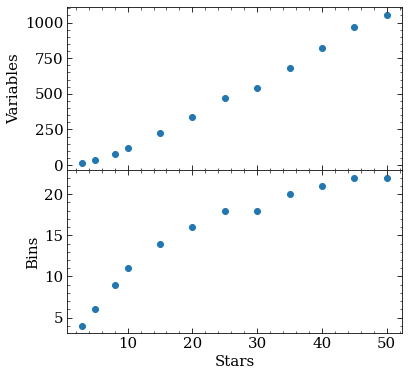

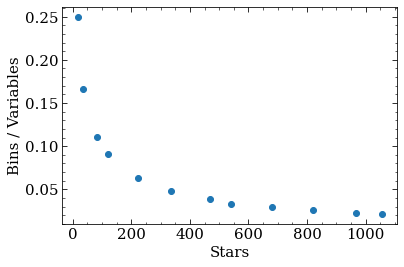

In [25]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, sharex = True, gridspec_kw={'hspace': 0}, figsize = (6, 6))
ax = axs[0] 
ax.scatter(N_min_vals, n_vars)
ax.set_ylabel('Variables')
ax = axs[1]
ax.scatter(N_min_vals, n_dim)
ax.set_xlabel('Stars')
ax.set_ylabel('Bins')
# ax.set_facecolor('white')
plt.show()

fig, ax = plt.subplots()
ax.scatter(n_vars, n_dim / n_vars)
ax.set_xlabel('Stars')
ax.set_ylabel('Bins / Variables')
plt.show()